# Quantization

### Imports

In [0]:
!pip install adversarial-robustness-toolbox

In [0]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.quantization
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.quantization import QuantStub, DeQuantStub
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
from torchvision import datasets, transforms
import numpy as np
from sklearn import metrics
import math
import os
import matplotlib.pyplot as plt

from art.attacks import CarliniL2Method, CarliniLInfMethod
from art.classifiers import PyTorchClassifier
from art.utils import load_mnist

%matplotlib inline
%config InlineBackend.figure_format='retina'

device = torch.device('cpu')

### Dataset

In [0]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

train_dataset = TensorDataset(torch.Tensor(x_train[:10000]), torch.Tensor(y_train[:10000]))
train_dataloader = DataLoader(train_dataset, batch_size=64)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)

### Load model

In [7]:
%cd '/content/drive/My Drive/FYP'

/content/drive/My Drive/FYP


In [0]:
pretrained_model = 'model_01.pth'

## Quantization-aware training

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)
        

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return x
    

def train_classifier(cl, opt, x, y):
    x.to(device)
    y.to(device)
    opt.zero_grad()
    pred = cl(x)
    pred.to(device)
    err = F.nll_loss(F.log_softmax(pred, dim=0), y)
    err.backward()
    opt.step()
    return err, pred

def test_model(cl,test_loader): 
    correct = 0
    with torch.no_grad():
        cl.eval()
        for data, target in test_loader:
            output = cl(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            target = np.argmax(target, axis=1)
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_loader.dataset))
        
    return acc_test

def print_size_of_model(model):
  torch.save(model.state_dict(), 'temp.p')
  print('Size (KB):', os.path.getsize("temp.p")/1e3)
  os.remove('temp.p')

In [26]:
EPOCHS = 4
BATCH_SIZE = 32

qat_model = Classifier().to(device)
qat_model.config = torch.quantization.get_default_qat_qconfig('fbgemm')
# prepare_qat performs the “fake quantization”, preparing the model for quantization-aware training
torch.quantization.prepare_qat(qat_model, inplace=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(qat_model.parameters(), lr=.001, weight_decay=0)

for e in range(EPOCHS):
    qat_model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        target = np.argmax(target, axis=1)  # transform from one-hot to int
        c_error,c_pred = train_classifier(qat_model, optimizer, data.to(device), target.to(device))
        quantized_model = torch.quantization.convert(qat_model.eval(), inplace=False)
    acc = test_model(quantized_model,test_dataloader)
    print("Epoch ", e, ": Test accuracy: ", 100*acc, "%")
print("Performance in the trained model")
print('Test Accuracy: ', test_model(quantized_model, test_dataloader)*100, '%')
print("FINISHED!!!")

/usr/local/lib/python3.6/dist-packages/torch/quantization/quantize.py:143: UserWarning: None of the submodule got qconfig applied. Make sure you passed correct configuration through `qconfig_dict` or by assigning the `.qconfig` attribute directly on submodules
  warnings.warn("None of the submodule got qconfig applied. Make sure you "


Epoch  0 : Test accuracy:  76.03999999999999 %
Epoch  1 : Test accuracy:  95.37 %
Epoch  2 : Test accuracy:  96.73 %
Epoch  3 : Test accuracy:  97.25 %
Performance in the trained model
Test Accuracy:  97.25 %
FINISHED!!!


In [0]:
torch.save(qat_model.state_dict(), 'qat_model_01.pth')

## Post-training static quantization

In [29]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)

        # Insert QuantStub and DeQuantStub at the beginning and end of the network.
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
        

    def forward(self, x):
        x = self.quant(x)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.reshape(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return self.dequant(x)
    

def train_classifier(cl, opt, x, y):
    x.to(device)
    y.to(device)
    opt.zero_grad()
    pred = cl(x)
    pred.to(device)
    err = criterion(pred, y)
    err.backward()
    opt.step()
    return err, pred

def test_model(cl,test_loader): 
    correct = 0
    with torch.no_grad():
        cl.eval()
        for data, target in test_loader:
            output = cl(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            target = np.argmax(target, axis=1)
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_loader.dataset))
        
    return acc_test

def print_size_of_model(model):
  torch.save(model.state_dict(), 'temp.p')
  print('Size (KB):', os.path.getsize("temp.p")/1e3)
  os.remove('temp.p')

# Substitute for the log_softmax(x, dim=1) and F.nll_loss(pred, y) due to CPU constraints
criterion = nn.CrossEntropyLoss()

# Initialize the model.
model = Classifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=.001, weight_decay=0)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

# Print size and accuracy of the model
print(model)
print_size_of_model(model)
print('Test Accuracy: ', test_model(model, test_dataloader)*100, '%')

Classifier(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
  (quant): QuantStub()
  (dequant): DeQuantStub()
)
Size (KB): 1098.478
Test Accuracy:  99.0 %


In [30]:
model.qconfig = torch.quantization.default_qconfig
print(model.qconfig)
torch.quantization.prepare(model, inplace=True)

# Calibrate with the training set
test_model(model, train_dataloader)
print('Post Training Quantization: Calibration done')

# Convert to quantized model
torch.quantization.convert(model, inplace=True)
print('Post Training Quantization: Convert done')
q_acc = test_model(model, test_dataloader)
print('Quantized evaluation accuracy: ',q_acc*100, '%')
print_size_of_model(model)

# Save model
torch.save(model.state_dict(), 'post-training_static_quantization.p')

QConfig(activation=functools.partial(<class 'torch.quantization.observer.MinMaxObserver'>, reduce_range=True), weight=functools.partial(<class 'torch.quantization.observer.MinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric))
Post Training Quantization: Calibration done
Post Training Quantization: Convert done
Quantized evaluation accuracy:  98.96000000000001 %
Size (KB): 279.772


In [32]:
model

Classifier(
  (conv1): QuantizedConv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), scale=0.03873421996831894, zero_point=92)
  (conv2): QuantizedConv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), scale=0.04679799824953079, zero_point=80)
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): QuantizedLinear(in_features=320, out_features=512, scale=0.07998918741941452, zero_point=83, qscheme=torch.per_tensor_affine)
  (fc2): QuantizedLinear(in_features=512, out_features=200, scale=0.10864441096782684, zero_point=69, qscheme=torch.per_tensor_affine)
  (fc3): QuantizedLinear(in_features=200, out_features=10, scale=0.3246079981327057, zero_point=125, qscheme=torch.per_tensor_affine)
  (quant): Quantize(scale=tensor([0.0079]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant): DeQuantize()
)

# Carlini

In [0]:
# Generate adversarial test examples
def CarliniL2(classifier, x_test, init_const):
    attack = CarliniL2Method(classifier=classifier,
                            confidence=0.0,
                            targeted=False,
                            learning_rate=0.01,
                            binary_search_steps=2,
                            initial_const=init_const,
                            batch_size=64)
    x_test_adv = attack.generate(x=x_test)

    return x_test_adv

def CarliniLInf(classifier, x_test, epsilon):
    attack = CarliniLInfMethod(classifier=classifier, 
                              confidence=0.0,
                              targeted=False, 
                              learning_rate=0.01,
                              eps=epsilon, 
                              batch_size=128)
    x_test_adv = attack.generate(x=x_test)
    
    return x_test_adv

# Calculate distance 
def L2distance(x_test, x_test_adv):
    dist = 0
    samples_changed = 0
    for test, adv_test in zip(x_test, x_test_adv):
        l2 = np.linalg.norm(test-adv_test)
        dist += l2
        samples_changed = samples_changed + 1 if l2>0 else samples_changed
    dist /= samples_changed
    return dist

In [34]:
# Make a classifier wrapper!
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Test model
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

Accuracy on benign test examples: 99.00999999999999 %


### L2

In [0]:
carlini_l2 = dict()
constants = [0.1, 0.5, 1.0, 2.5, 5, 10]
n = 1000
accuracies = []
distances = []
for init in constants:
    x_test_adv = CarliniL2(classifier, x_test[:n], init_const=init)
    predictions = classifier.predict(x_test_adv)
    acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
    accuracies.append(round(acc, 3))
    dist = L2distance(x_test[:n], x_test_adv)
    distances.append(round(dist, 3))

    print('c:', init, ' Accuracy:', acc, ' Distance:', round(distances[-1], 3))

### LInf

In [31]:
epsilons = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
n = 1000
accuracies = []
for eps in epsilons:
    x_test_adv = CarliniLInf(classifier, x_test[:n], epsilon=eps)
    predictions = classifier.predict(x_test_adv)
    acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
    accuracies.append(round(acc, 3))

    print('eps:', eps, ' Accuracy:', acc)

print(accuracies)

eps: 0.01  Accuracy: 0.964
eps: 0.1  Accuracy: 0.875
eps: 0.2  Accuracy: 0.654
eps: 0.3  Accuracy: 0.419
eps: 0.4  Accuracy: 0.206
eps: 0.5  Accuracy: 0.107
eps: 0.6  Accuracy: 0.077
[0.964, 0.875, 0.654, 0.419, 0.206, 0.107, 0.077]


## Results

In [32]:
accuracies

[0.964, 0.875, 0.654, 0.419, 0.206, 0.107, 0.077]

In [30]:
distances

[0.183, 0.96, 1.554, 2.139, 2.497, 2.765]

In [0]:
qat_acc_vanilla = np.mean([
  [0.961, 0.804, 0.563, 0.237,  0.125, 0.078],
  [0.954, 0.761, 0.507, 0.217, 0.109, 0.073]
], axis=0)

qat_dist_vanilla = np.mean([
  [0.172, 0.904,  1.478, 2.144, 2.479, 2.803],
  [0.183, 0.96, 1.554, 2.139, 2.497, 2.765]
], axis=0)

qat_eps_vanilla = np.mean([
  [0.964, 0.872, 0.658, 0.42, 0.242, 0.125, 0.085],
  [0.964, 0.875, 0.654, 0.419, 0.206, 0.107, 0.077]
], axis=0)

### L2

In [0]:
qat_carlini = {
    'No quantization': [0.979, 0.833, 0.563, 0.212, 0.096, 0.062],
    'Quantization-aware training': qat_acc_vanilla
}
qat_dist_carlini = {
    'No quantization': [0.271, 1.275, 2.017, 2.692, 3.117, 3.46],
    'Quantization-aware training': qat_dist_vanilla
}

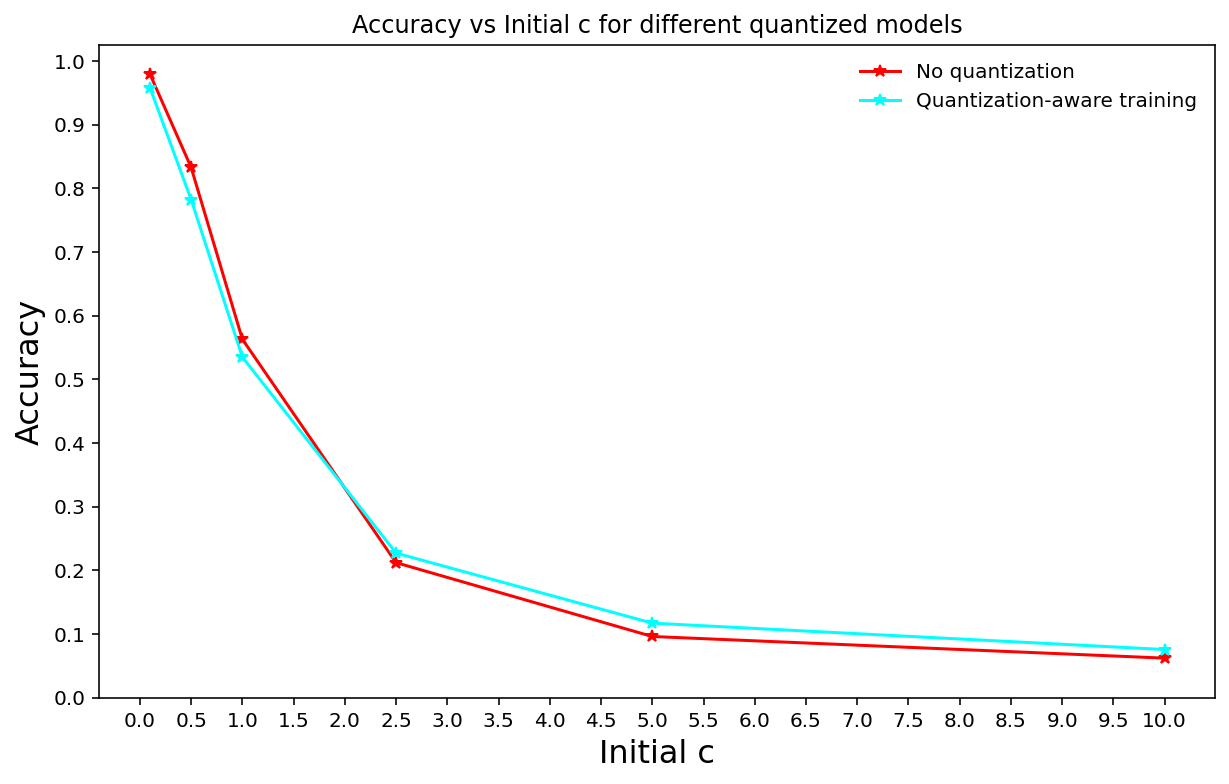

In [37]:
# plot the pruned accuracies vs constant c

plt.figure(figsize=(10,6))
colors =  ['red', 'aqua', 'gold', 'lime']

for idx, (decay, results) in enumerate(qat_carlini.items()):
    plt.plot(constants, results, "*-", color=colors[idx], label="{}".format(decay))

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 10.1, step=0.5))
plt.title("Accuracy vs Initial c for different quantized models")
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

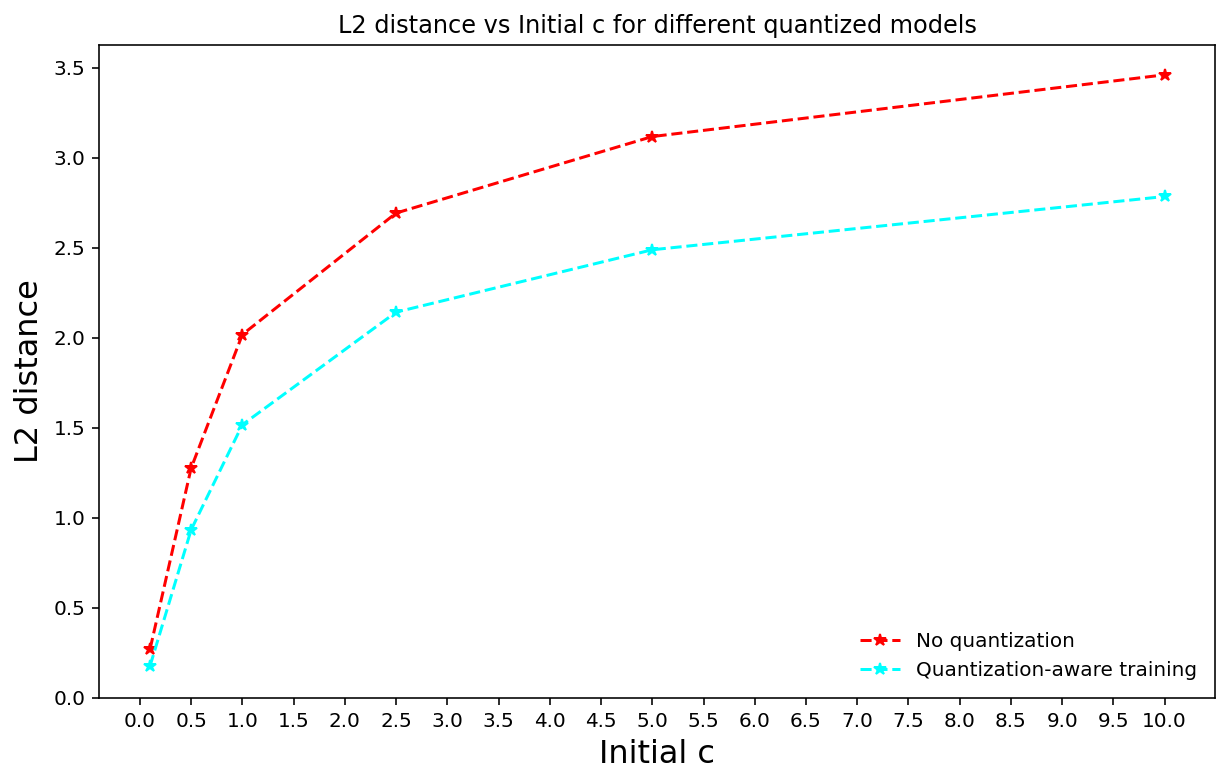

In [43]:
# plot the pruned accuracies vs constant c

plt.figure(figsize=(10,6))
colors =  ['red', 'aqua', 'gold', 'lime']

for idx, (decay, results) in enumerate(qat_dist_carlini.items()):
    plt.plot(constants, results, "*--", color=colors[idx], label="{}".format(decay))

plt.yticks(np.arange(0, 3.6, step=0.5))
plt.xticks(np.arange(0, 10.1, step=0.5))
plt.title("L2 distance vs Initial c for different quantized models")
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("L2 distance",fontsize=16)
plt.legend(loc='lower right', frameon=False)
plt.show()

### LInf

In [0]:
qat_carlini = {
    'No quantization': [0.987, 0.929, 0.78, 0.568, 0.368, 0.197, 0.108],
    'Quantization-aware training': qat_eps_vanilla
}

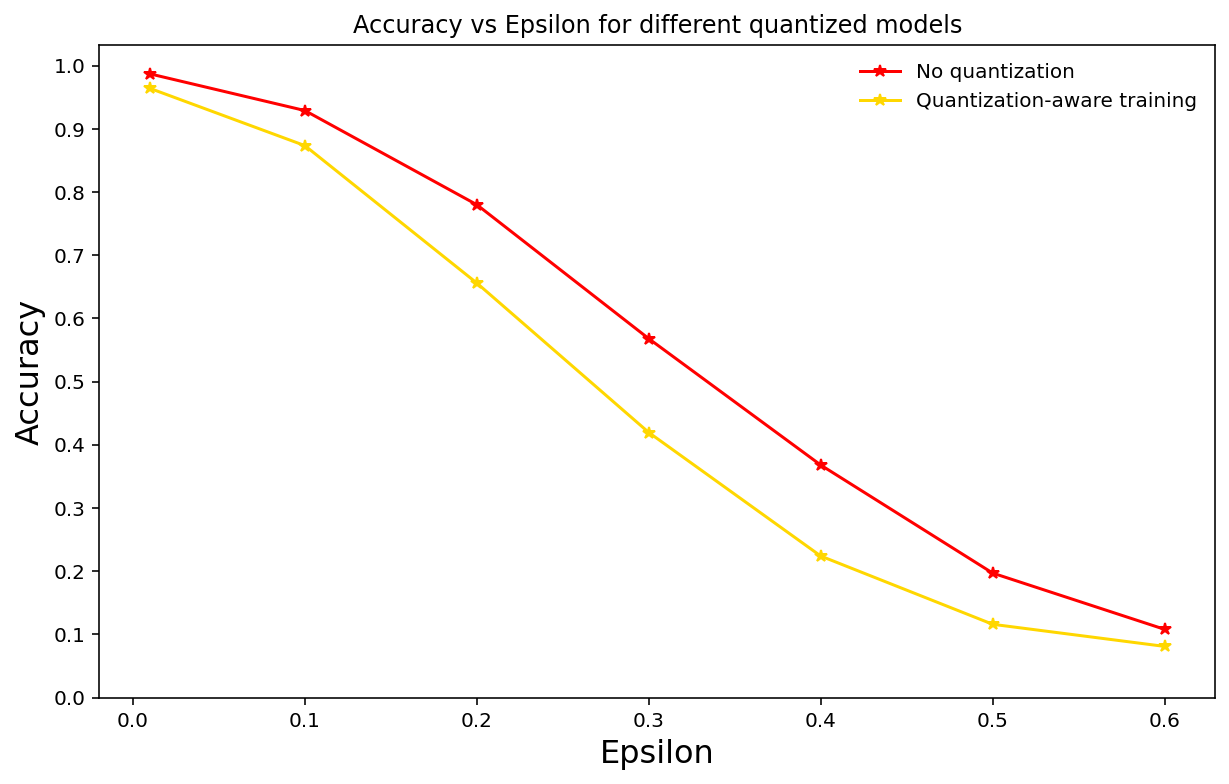

In [45]:
# plot the pruned accuracies vs epsilon

plt.figure(figsize=(10,6))
colors =  ['red', 'gold', 'gold', 'lime']

for idx, (decay, results) in enumerate(qat_carlini.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label="{}".format(decay))

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.61, step=0.1))
plt.title("Accuracy vs Epsilon for different quantized models")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()